<a href="https://colab.research.google.com/github/zzbn12345/FCIC24_Workshop_AI/blob/main/Lecture2_Social_and_Spatial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMPUATIONAL RESEARCH METHODS FOR THE BUILT ENVIRONMENT

## Lecture 2: Social and Spatial Networks in the Built Environment
Dr. Nan BAI

24 April 2024, Trial Lecture AE+T Sector Plan

Postdoc Research Fellow in Data Science and Artificial Intelligence | Public Administration and Policy Group | Wageningen University & Research

Guest Researcher | Marie Sklodowska-Curie Early-Stage Researcher | Department of Architectural Engineering + Technology | Delft University of Technology

### Introduction

This is a Python notebook hosted on Google Colab that you can follow to reproduce many of the results presented during the **Lecture 2 Social and Spatial Networks in the Built Environment**.

You have the chance to bring in your own case-study city and collect your own network datasets in ready-to-use formats for further research and heritage investigations. You can try to represent the city as a graph, and find out the nodes with the highest degrees and other centrality metrics.

You probably need some knowledge in programming to understand what happens in each part. However, it does not matter that much if you do not. Just walk through all the steps and you will at least have some interesting results at hand.

After this lecture, you will have the:
* **[Knowledge]** to describe a social network of people in space and a spatial network in the built environment (building/cities) using the terminology of network **centrality** analysis

* **[Skills]** to construct a social or a spatial network and represent the network structure that can be understood by computers

* **[Attitude]** to prepare spatial network models for describing the urban built heritage using computational tools

### Basic Settings and Preparations

#### Imports and Installations

In [ ]:
!pip install flickrapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 1.0 MB/s eta 0:00:00


In [ ]:
!pip install rasterfairy

  Preparing metadata (setup.py) ... done
  Created wheel for rasterfairy: filename=rasterfairy-1.0.6-py3-none-any.whl size=29531 sha256=3add357648a5babc4dbe08251a2e6b8eda5b70ad89bf321ad87e6703563560b4
  Stored in directory: /root/.cache/pip/wheels/96/22/02/8d803d027886f08306053833a687b5a5f7f052d1b8b00462d8
Successfully built rasterfairy


In [ ]:
import flickrapi
import json
import pandas as pd
import numpy as np
from argparse import Namespace
import urllib
import pickle
import random
import os
from google.colab import userdata
from google.colab import drive
import pathlib
import re
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from scipy.spatial import distance

from sklearn.manifold import TSNE
from PIL import Image

#### Mounting Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


After mounting to the Google Drive, you can see its folders by clicking on the Files tab on the left of the Colab notebook. You can also access your downloaded data later.

#### Making a Folder for this Workshop

First tell us how you would love to call your case study city! Please do not use any space in the name. Next time you can also change this case name for another case study that you are interested in.

In [ ]:
case_name = 'FAUP_Porto'

Let's make a new folder in your Google Drive for the rest of this project

In [ ]:
folder = '/content/drive/MyDrive/FCIC_workshop/' + case_name + '/'
pathlib.Path(folder).mkdir(parents=True, exist_ok=True)

#### User Inputs

In [ ]:
args = Namespace(
    # Please paste your API key and secret in your Google Colab environment
    api_key = u'{}'.format(userdata.get('api_key')),
    api_secret = u'{}'.format(userdata.get('api_secret')),
    # Please paste the geolocation of your case study city here
    lat = 41.150505,
    lon = -8.636225,
    # The radius is in the unit of km
    radius = 0.5,
    save_dir = folder + 'data_storage/',
    image_dir = folder + 'data_storage/images/',
    # Set a limit to the images to be collected
    maximum_images = 400,
    tags = None
)

In [ ]:
args.save_dir

'/content/drive/MyDrive/FCIC_workshop/FAUP_Porto/data_storage/'

#### Some Pre-defined Functions to be used

In [ ]:
def collect_ids(flickr, lat, lon, radius, tags = None):

    if 'photo_ids.csv' in [files for root, dirs, files in os.walk(args.save_dir)][0]:
        Ids = pd.read_csv(args.save_dir+'photo_ids.csv', sep='\t')['ids'].tolist()
    else:
        Ids = []

    walk = flickr.walk(has_geo = 1, lat = args.lat, lon = args.lon, radius = args.radius, tags=args.tags)
    for photo in walk:
        id_now = photo.get('id')
        if id_now in Ids:
            continue
        Ids.append(id_now)
        if len(Ids)%50 == 0:
            print('{} photo ids collected'.format(len(Ids)))
            pd.Series(Ids, name = 'ids').to_csv(args.save_dir + 'photo_ids.csv', index=False)
        if len(Ids)>=args.maximum_images:
          break
    pd.Series(Ids, name = 'ids').to_csv(args.save_dir + 'photo_ids.csv', index=False)
    return Ids

In [ ]:
def get_photos(flickr, Photos, Ids):
    processed = Photos.keys()
    for id_now in Ids:
        if id_now in processed:
            continue
        else:
            Photos[id_now] = {}
            sizes = json.loads(flickr.photos.getSizes(photo_id = id_now, format='json'))
            info = json.loads(flickr.photos.getInfo(photo_id = id_now, format='json'))
            try:
                url_c = sizes['sizes']['size'][-2]['source']
                url_q = sizes['sizes']['size'][1]['source']
                can = sizes['sizes']['candownload']
                Photos[id_now]['candownload'] = can
                Photos[id_now]['url_q'] = url_q
                Photos[id_now]['owner'] = info['photo']['owner']['nsid']
                Photos[id_now]['owner_loc'] = info['photo']['owner']['location']
                Photos[id_now]['title'] = info['photo']['title']['_content']
                Photos[id_now]['description'] = info['photo']['description']['_content']
                Photos[id_now]['comments'] = info['photo']['comments']['_content']
                Photos[id_now]['taken'] = info['photo']['dates']['taken']
                Photos[id_now]['views'] = info['photo']['views']
                Photos[id_now]['people'] = info['photo']['people']['haspeople']
                Photos[id_now]['tags'] = info['photo']['tags']['tag']
                Photos[id_now]['lat'] = info['photo']['location']['latitude']
                Photos[id_now]['lon'] = info['photo']['location']['longitude']
                Photos[id_now]['neighbourhood'] = info['photo']['location']['neighbourhood']['_content']
                Photos[id_now]['url'] = info['photo']['urls']['url'][0]['_content']

                if can:
                    urllib.request.urlretrieve(url_q, args.image_dir+'{}.jpg'.format(id_now))

                if len(processed)%50 ==0:
                    print('{}/{} photos collected'.format(len(processed),len(Ids)))
                    with open(args.image_dir+'Photo_sizes.p', 'wb') as fp:
                        pickle.dump(Photos,fp, protocol=pickle.HIGHEST_PROTOCOL)
                    photo_df = pd.DataFrame(Photos).T
                    photo_df.to_csv(args.image_dir+'photos_sizes.csv', sep='\t',encoding='utf-8-sig')
            except:
                print(id_now)
                continue

    with open(args.image_dir+'Photo_sizes.p', 'wb') as fp:
        pickle.dump(Photos,fp, protocol=pickle.HIGHEST_PROTOCOL)
    photo_df = pd.DataFrame(Photos).T
    photo_df.to_csv(args.image_dir+'photos_sizes.csv', sep='\t',encoding='utf-8-sig')
    return Photos

In [ ]:
def load_image(path):
    img = image.load_img(path, target_size=[224,224])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    return img, x

In [ ]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

### Data Collection

Colleting the Photo IDs of social media posts that fulfills the requirements within the case study area. This step is very fast (a few seconds).

In [ ]:
flickr = flickrapi.FlickrAPI(args.api_key, args.api_secret)
if not 'data_storage' in os.listdir(folder):
  os.mkdir(args.save_dir)
Ids = collect_ids(flickr, args.lat, args.lon, args.radius, args.tags)

In [ ]:
len(Ids)

401

Collecting the actual photos with the IDs that has been collected in the last step. This step might take a while (a few minutes).

In [ ]:
if not 'images' in os.listdir(args.save_dir):
  os.mkdir(args.image_dir)

if 'Photo_sizes.p' in [files for root, dirs, files in os.walk(args.image_dir)][0]:
  with open(args.image_dir+'Photo_sizes.p', 'rb') as fp:
      Photos = pickle.load(fp)
else:
  Photos = {}
  Photos = get_photos(flickr, Photos, Ids)

In [ ]:
len(Photos)

450

Congratulations! Now you have your first dataset in your case study city with 400 small-size images! You can check them out in your Google Drive folder "FCIC_workshop/[your_case_study]/data_storage/images".

Since we only have very little time during the workshop, we just collect very few images that might not be representative enough in your area. But you can later increase the number of "maximum_images" to collect more images when you have more time. Note that you might get an error with FlickrAPI because you have called it too many times. Don't worry, just run the last cell again and you will find that the download continues from the last checkpoint, and not from the very beginning ;)!

### Dataset Exploration

#### Downloaded Images

This pandas dataframe contains the collected dataset.

In [ ]:
img_df = pd.read_csv(args.image_dir+'photos_sizes.csv',sep='\t').rename(columns={'Unnamed: 0':'ids'})
img_df.head()

ids  candownload  \
0  53440346026            0   
1  53435181869            0   
2  53424054099            0   
3  53417600202            0   
4  53413760498            0   

                                               url_q         owner owner_loc  \
0  https://live.staticflickr.com/65535/5344034602...  48597791@N04       NaN   
1  https://live.staticflickr.com/65535/5343518186...  48597791@N04       NaN   
2  https://live.staticflickr.com/65535/5342405409...  48597791@N04       NaN   
3  https://live.staticflickr.com/65535/5341760020...  48597791@N04       NaN   
4  https://live.staticflickr.com/65535/5341376049...  48597791@N04       NaN   

                             title  \
0           Tram 131 at Massarelos   
1  Museum horse tram 8 at Arrábida   
2           Zorra 58 at Massarelos   
3       Museumtram 100 at Arrábida   
4      Musemtram 104 at Massarelos   

                                         description  comments  \
0                                              Porto         0   
1            Annual Porto museumtrams parade of 2023         0   
2  At the end of the annual Porto museumtrams par...         0   
3            Annual Porto museumtrams parade of 2023         0   
4  In advance of the 2023 Porto annual museum tra...         0   

                 taken  views  people  \
0  2023-05-13 18:42:17     82       0   
1  2023-05-13 15:49:09    164       0   
2  2023-05-13 17:44:15    231       0   
3  2023-05-13 15:50:00    148       0   
4  2023-05-13 14:39:21    165       0   

                                                tags        lat       lon  \
0  [{'id': '48565652-53440346026-32298', 'author'...  41.147397 -8.633303   
1  [{'id': '48565652-53435181869-32298', 'author'...  41.148547 -8.641056   
2  [{'id': '48565652-53424054099-32298', 'author'...  41.147552 -8.633748   
3  [{'id': '48565652-53417600202-32298', 'author'...  41.148613 -8.641064   
4  [{'id': '48565652-53413760498-32298', 'author'...  41.145961 -8.631125   

  neighbourhood                                                url  
0    Massarelos  https://www.flickr.com/photos/ernstkers/534403...  
1           NaN  https://www.flickr.com/photos/ernstkers/534351...  
2    Massarelos  https://www.flickr.com/photos/ernstkers/534240...  
3           NaN  https://www.flickr.com/photos/ernstkers/534176...  
4    Massarelos  https://www.flickr.com/photos/ernstkers/534137...

In [ ]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ids            450 non-null    int64  
 1   candownload    450 non-null    int64  
 2   url_q          450 non-null    object 
 3   owner          450 non-null    object 
 4   owner_loc      188 non-null    object 
 5   title          420 non-null    object 
 6   description    275 non-null    object 
 7   comments       450 non-null    int64  
 8   taken          450 non-null    object 
 9   views          450 non-null    int64  
 10  people         450 non-null    int64  
 11  tags           450 non-null    object 
 12  lat            450 non-null    float64
 13  lon            450 non-null    float64
 14  neighbourhood  228 non-null    object 
 15  url            450 non-null    object 
dtypes: float64(2), int64(5), object(9)
memory usage: 56.4+ KB


Note if "candownload" is marked as 0, the photo is not downloaded to your folder. Therefore, only a subset of the images are downloaded.

In [ ]:
img_df['candownload'].sum()

208

In [ ]:
len([n for n in os.listdir(args.image_dir) if n[-3:]=='jpg'])

208

#### Simple Visualization of an Image

The top 5% viewed images downloaded is visualized together, in a descending order

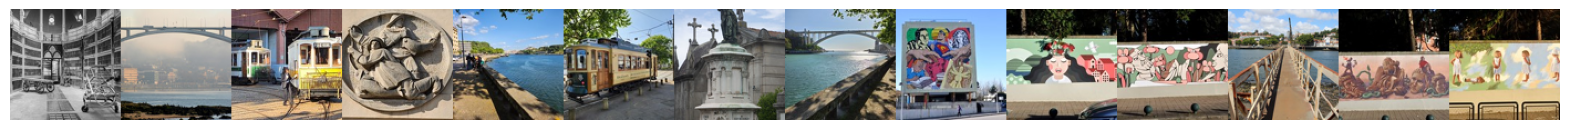

In [ ]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in img_df[img_df['views']>img_df['views'].quantile(0.95)].sort_values(by='views', ascending=False)['ids']:
    try:
        img = image.load_img(args.image_dir+str(idx)+'.jpg')
        img = img.resize((int(img.width * 100 / img.height), 100))
        thumbs.append(img)
    except:
        continue

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (20,12))
plt.axis('off')
plt.imshow(concat_image)

#### Geographic Distribution

This collection of posts are posted by people from the following places:

In [ ]:
img_df['owner_loc'].unique()

array([nan, 'Vila Nova de Gaia, Portugal', 'Skipton, North Yorkshire, UK',
       'Argentona, Barcelona', 'Entre-Deux, Réunion', 'Portugal',
       'Jerusalem', 'Roskilde, Denmark', 'Charlottesville, Virginia, USA',
       'Madrid, España', 'Nottingham, England', 'Porto, Portugal',
       'Springfield, VA, USA', 'tv, preganziol', 'Misgav, Israel',
       'Santiago, Chile', 'Brazil', 'Potsdam, Deutschland', 'Berlin',
       'Porto, Portugal., Portugal', 'Tomar, Portugal',
       'Windsor, ON, Canada', 'Horsham, UK', 'London, United Kingdom',
       'Croydon', 'France', 'Montréal, Canada'], dtype=object)

We can visualize the geolocations of the posts with their respective number of viewers on Flickr

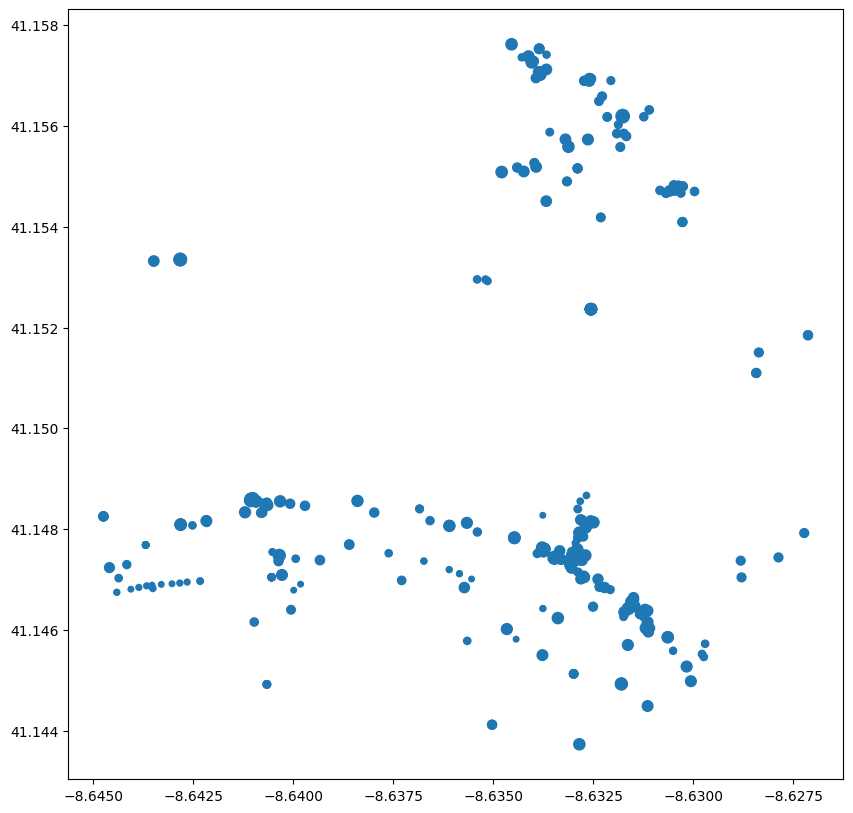

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(img_df['lon'],img_df['lat'], s=10*np.log(img_df['views']+5))

You can already observe that the distribution of collected posts are scattering around the area, if you are familiar enough. It will be more readable if being overlaid with the real urban network from Open Street Map.

In [ ]:
tags= tags={'amenity': True, 'highway':True, 'landuse':True, 'building':True, 'waterway': True, 'railway': True}
all_geom=ox.features.features_from_point((args.lat, args.lon),  tags, dist=args.radius * 1500)
#all_geom = all_geom.to_crs(epsg=3857)

In [ ]:
G = ox.graph_from_point((args.lat, args.lon), dist=args.radius * 1500, network_type='all')
G_proj = ox.projection.project_graph(G, to_latlong=True)

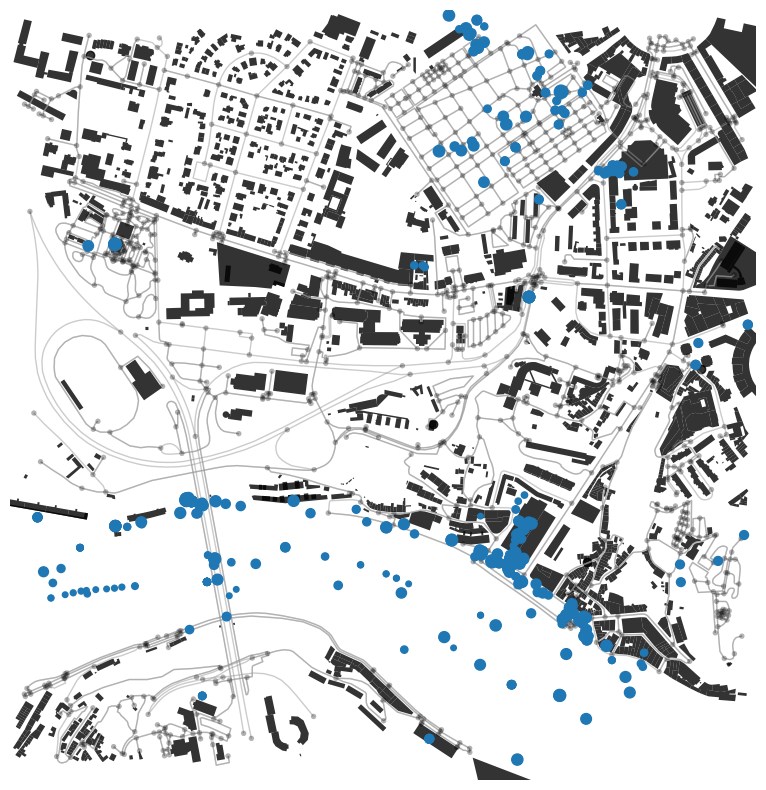

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
all_geom[all_geom['building'].notna()].plot(ax=ax,color='black', alpha=0.8)
ox.plot_graph(G_proj, figsize=(10, 10), bgcolor='w', node_color='k', node_alpha = 0.3, edge_alpha = 0.5, ax=ax, show=False)

ax.scatter(img_df['lon'],img_df['lat'], s=10*np.log(img_df['views']+5))
plt.axis('off')
plt.show()

#### Temporal Distribution

In [ ]:
img_df['date'] = img_df['taken'].apply(lambda x: int(x[:4]))

In [ ]:
img_df['date'].describe()

count     450.000000
mean     2020.608889
std         6.280235
min      1960.000000
25%      2019.000000
50%      2023.000000
75%      2023.000000
max      2023.000000
Name: date, dtype: float64

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


<Axes: >

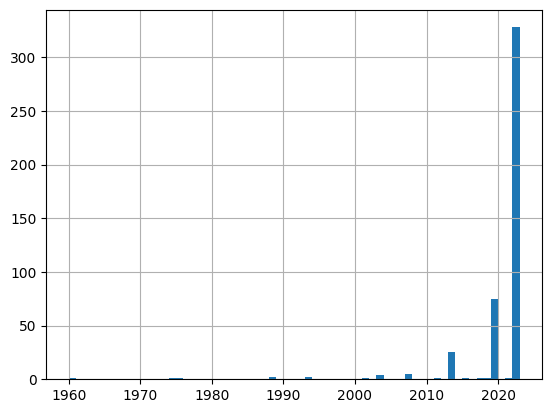

In [ ]:
img_df['date'].hist(bins=img_df['date'].max() - img_df['date'].min())

### Image Processing using AI Models

#### Loading a Pre-Trained Computer Vision Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Extrating the Visual Features of Images

In [ ]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

In [ ]:
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(args.image_dir) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 208 images to analyze


In [ ]:
import time
tic = time.perf_counter()

features = []
for i, image_path in enumerate(images):
    if i % 50 == 0:
        toc = time.perf_counter()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.perf_counter()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x, verbose=False)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 208. Time: 0.0003 seconds.
analyzing image 50 / 208. Time: 9.8016 seconds.
analyzing image 100 / 208. Time: 3.7059 seconds.
analyzing image 150 / 208. Time: 4.0264 seconds.
analyzing image 200 / 208. Time: 4.7585 seconds.
finished extracting features for 208 images


In [ ]:
feat.shape

(4096,)

The images are represented as a 4096-dimensional vector

#### Dimensionality Reduction

We can then reduce the dimensions of image features to 100-dimension using Principal Component Analysis...

In [ ]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=100)
pca.fit(features)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


PCA(n_components=100)

In [ ]:
pca_features = pca.transform(features)

In [ ]:
features.shape

(208, 4096)

In [ ]:
pca_features.shape

(208, 100)

In [ ]:
with open(args.save_dir + 'feature_PCA.p', 'wb') as fp:
  pickle.dump([images, pca_features, pca], fp)

#### Image Extraction

We can already use this reduced feature to extrac close images to any sample

Text(0.5, 1.0, 'query image (186)')

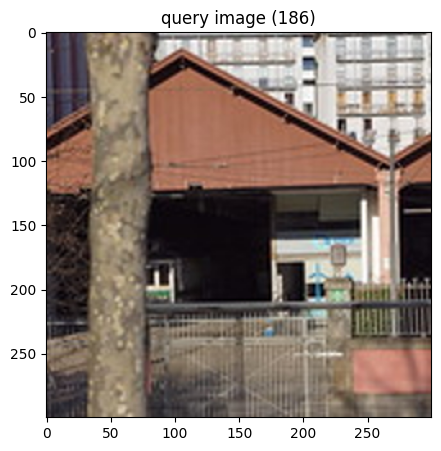

In [ ]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

Text(0.5, 1.0, 'result images')

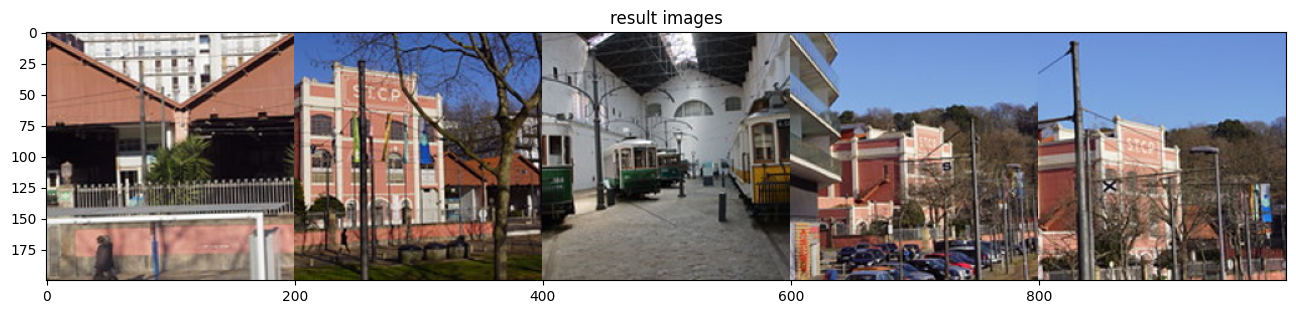

In [ ]:
# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

Text(0.5, 1.0, 'query image (169)')

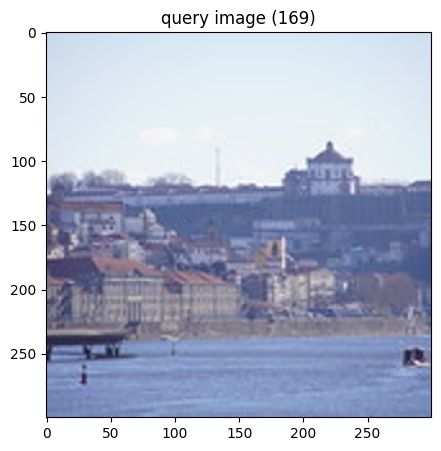

In [ ]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

Text(0.5, 1.0, 'result images')

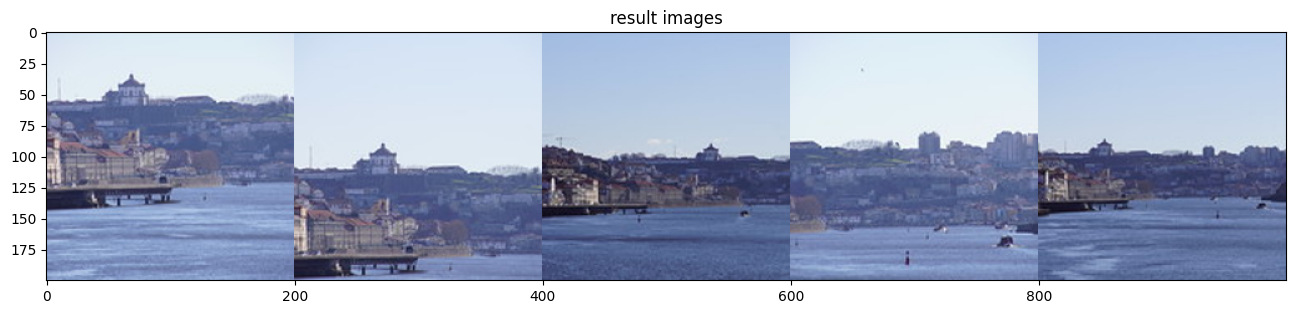

In [ ]:
# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

#### Using t-SNE to visualize the similarities of images on 2D

In [ ]:
with open(args.save_dir + 'feature_PCA.p', 'rb') as fp:
  images, pca_features, pca = pickle.load(fp)

In [ ]:
num_images_to_plot = 200
random.seed(1)
if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [ ]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 30.260782
[t-SNE] Computed conditional probabilities in 0.027s
[t-SNE] Iteration 50: error = 64.0051498, gradient norm = 0.3368674 (50 iterations in 0.391s)
[t-SNE] Iteration 100: error = 63.7776566, gradient norm = 0.3242003 (50 iterations in 0.293s)
[t-SNE] Iteration 150: error = 63.8155823, gradient norm = 0.3427885 (50 iterations in 0.220s)
[t-SNE] Iteration 200: error = 69.5600433, gradient norm = 0.2836042 (50 iterations in 0.455s)
[t-SNE] Iteration 250: error = 63.2207642, gradient norm = 0.3171518 (50 iterations in 0.241s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.220764
[t-SNE] Iteration 300: error = 0.5426528, gradient norm = 0.0064189 (50 iterations in 0.204s)
[t-SNE] Iteration 350: error = 0.4682170, gradient norm = 0.0014810 

In [ ]:
len(X)

200

In [ ]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

<ipython-input-59-809a09023e91>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)


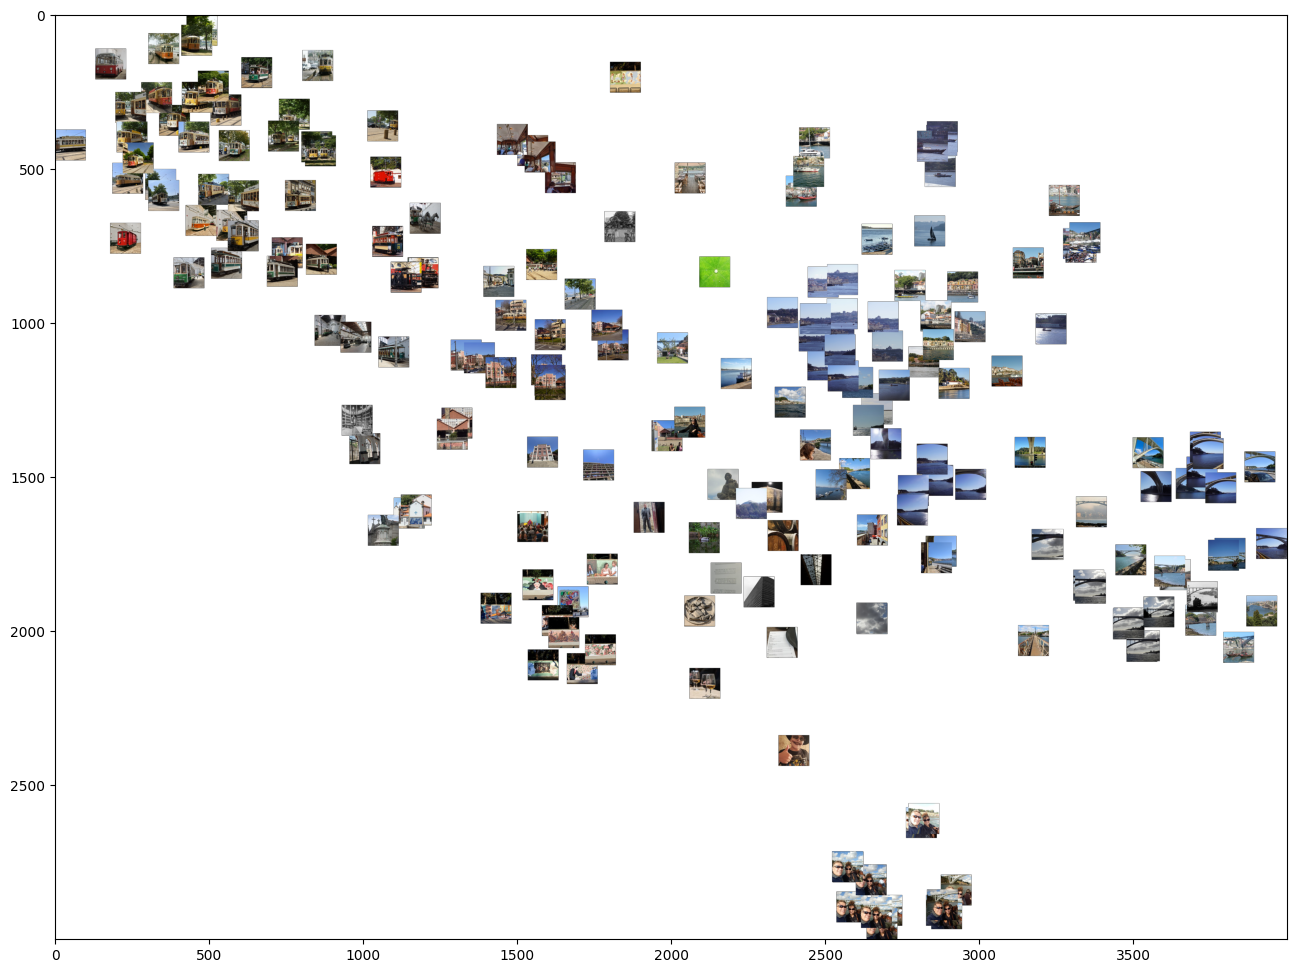

In [ ]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (16,12))
plt.imshow(full_image)

In [ ]:
full_image.save(args.save_dir + "tSNE_200.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tsne_path = args.save_dir + "tSNE_200.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to /content/drive/MyDrive/FCIC_workshop/FAUP_Porto/data_storage/tSNE_200.json


#### Stretching the TSNE visualization into a grid

In [ ]:
import rasterfairy

# nx * ny = 200, the number of images
nx = 20
ny = 10

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/rasterfairy/rasterfairy.py:134: DeprecationWarning: `np.float` is a deprecated alias for the bu

<ipython-input-61-65f548a41a6a>:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)


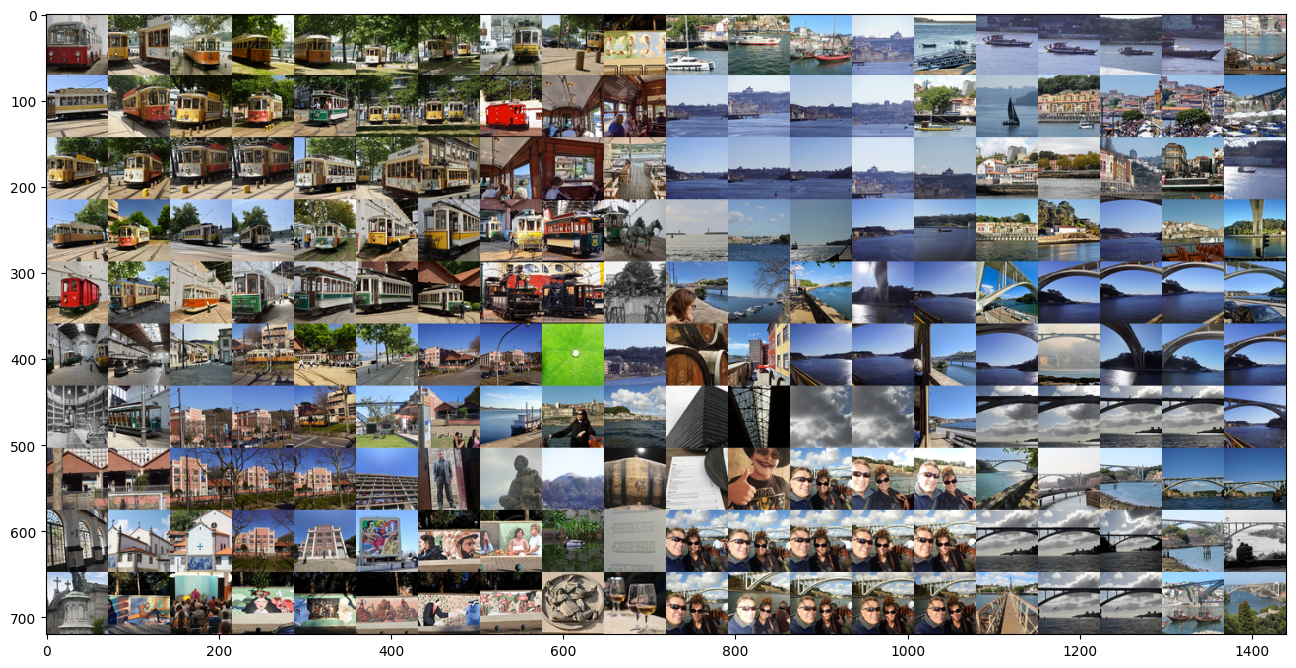

In [ ]:
tile_width = 72
tile_height = 72

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y

    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,12))
plt.imshow(grid_image)

In [ ]:
grid_image.save(args.save_dir + "grid_200.jpg")

This is a collage with very small number of images. If extended to larger number, images with much more insights can be generated.

See the following an example created with 1000 images in Testaccio area in Rome (Bai et al., 2023).

![<img src="image.png" width="2000"/>](https://drive.google.com/uc?id=1RHQ_MKroe6WSJLLjBZ88dNiGTgEkMBHq)



### Text Processing using AI Models

#### Preprocessing of Textual Information

A subset that has textual information of Description, Title, and Tags

In [ ]:
img_df['tag_list'] = img_df['tags'].apply(lambda x: re.findall(r'_content\': \'([a-zA-Z]+)',x))
img_df['tag_len'] = img_df['tag_list'].apply(lambda x: len(x))

In [ ]:
df_new = img_df[~((img_df['description'].isnull())|(img_df['title'].isnull())|(img_df['tag_len']==0))]
df_new

ids  candownload  \
0    53440346026            0   
1    53435181869            0   
2    53424054099            0   
3    53417600202            0   
4    53413760498            0   
..           ...          ...   
439  53402187150            0   
444  53396027508            0   
445  53382261598            0   
446  53376124675            0   
449  53337201506            0   

                                                 url_q         owner  \
0    https://live.staticflickr.com/65535/5344034602...  48597791@N04   
1    https://live.staticflickr.com/65535/5343518186...  48597791@N04   
2    https://live.staticflickr.com/65535/5342405409...  48597791@N04   
3    https://live.staticflickr.com/65535/5341760020...  48597791@N04   
4    https://live.staticflickr.com/65535/5341376049...  48597791@N04   
..                                                 ...           ...   
439  https://live.staticflickr.com/65535/5340218715...  48597791@N04   
444  https://live.staticflickr.com/65535/5339602750...  48597791@N04   
445  https://live.staticflickr.com/65535/5338226159...  48597791@N04   
446  https://live.staticflickr.com/65535/5337612467...  48597791@N04   
449  https://live.staticflickr.com/65535/5333720150...  48597791@N04   

    owner_loc                                 title  \
0         NaN                Tram 131 at Massarelos   
1         NaN       Museum horse tram 8 at Arrábida   
2         NaN                Zorra 58 at Massarelos   
3         NaN            Museumtram 100 at Arrábida   
4         NaN           Musemtram 104 at Massarelos   
..        ...                                   ...   
439       NaN          Museumtram 247 at Massarelos   
444       NaN            Museumtram 274 at Arrábida   
445       NaN            Museumtram 315 at Arrábida   
446       NaN                Tram 191 at Massarelos   
449       NaN  Museumtrams 274 and 58 at Massarelos   

                                           description  comments  \
0                                                Porto         0   
1              Annual Porto museumtrams parade of 2023         0   
2    At the end of the annual Porto museumtrams par...         0   
3              Annual Porto museumtrams parade of 2023         0   
4    In advance of the 2023 Porto annual museum tra...         0   
..                                                 ...       ...   
439  At the end of the annual Porto museumtrams par...         0   
444            Annual Porto museumtrams parade of 2023         0   
445            Annual Porto museumtrams parade of 2023         0   
446       Porto, the tram is going to enter the depot.         0   
449  At the end of the annual Porto museumtrams par...         0   

                   taken  views  people  \
0    2023-05-13 18:42:17     82       0   
1    2023-05-13 15:49:09    164       0   
2    2023-05-13 17:44:15    231       0   
3    2023-05-13 15:50:00    148       0   
4    2023-05-13 14:39:21    165       0   
..                   ...    ...     ...   
439  2023-05-13 18:56:57    190       0   
444  2023-05-13 15:51:06    236       0   
445  2023-05-13 15:50:45    223       0   
446  2023-05-13 18:58:07    215       0   
449  2023-05-13 17:46:11    268       0   

                                                  tags        lat       lon  \
0    [{'id': '48565652-53440346026-32298', 'author'...  41.147397 -8.633303   
1    [{'id': '48565652-53435181869-32298', 'author'...  41.148547 -8.641056   
2    [{'id': '48565652-53424054099-32298', 'author'...  41.147552 -8.633748   
3    [{'id': '48565652-53417600202-32298', 'author'...  41.148613 -8.641064   
4    [{'id': '48565652-53413760498-32298', 'author'...  41.145961 -8.631125   
..                                                 ...        ...       ...   
439  [{'id': '48565652-53402187150-32298', 'author'...  41.147377 -8.633123   
444  [{'id': '48565652-53396027508-32298', 'author'...  41.148558 -8.641056   
445  [{'id': '48565652-53382261598-32298', 'a

In [ ]:
df_new['tag_text'] = df_new['tag_list'].apply(lambda x: ', '.join(x))
df_new['TEXTS'] = 'Title: ' + df_new['title'] + '. Description: '+ df_new['description'] + '. Tags: '+ df_new['tag_text']

<ipython-input-64-477ab344b044>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['tag_text'] = df_new['tag_list'].apply(lambda x: ', '.join(x))
<ipython-input-64-477ab344b044>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['TEXTS'] = 'Title: ' + df_new['title'] + '. Description: '+ df_new['description'] + '. Tags: '+ df_new['tag_text']


In [ ]:
df_new['TEXTS'].iloc[10]

'Title: Museumtrams 274 and 58 at Massarelos. Description: At the end of the annual Porto museumtrams parade of 2023.. Tags: streetcar, trolley, strasenbahn, zorra, stcp, tram, sp, bonde, stcp, stcp, portugal, el, porto, publictransport, tranvia, tramvia'

In [ ]:
candidates = df_new['TEXTS'].drop_duplicates(keep='first')
len(candidates)

98

In [ ]:
candidates

0      Title: Tram 131 at Massarelos. Description: Po...
1      Title: Museum horse tram 8 at Arrábida. Descri...
2      Title: Zorra 58 at Massarelos. Description: At...
3      Title: Museumtram 100 at Arrábida. Description...
4      Title: Musemtram 104 at Massarelos. Descriptio...
                             ...                        
394    Title: Tram no.216 ascends Rua da Restauração....
395    Title: Tram 104 at Arrabida. Description: Annu...
397    Title: Portugal - Porto. Description: Cemitéri...
398    Title: Favolaschia calocera. Description: Fung...
399    Title: Clathrus ruber. Description: Fungos do ...
Name: TEXTS, Length: 98, dtype: object

#### Applying Sentiment Analysis

We define a function analyze_sentiment that takes a text as input, uses the NLTK library to perform sentiment analysis, and classifies the sentiment as positive, negative, or neutral.
The function is applied to the 'title' column of the DataFrame.

In [ ]:
import pandas as pd

# Install necessary libraries
!pip install nltk

# Import libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('vader_lexicon')

# Function for sentiment analysis
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)['compound']

    if sentiment_score >= 0.05:
        return 'Positive'
    elif sentiment_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to the 'title' column
df_new['sentiment'] = df_new['TEXTS'].apply(analyze_sentiment)

# Display the DataFrame with sentiment analysis results
print("\nDataFrame with Sentiment Analysis:")
print(df_new[['TEXTS', 'sentiment']])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



DataFrame with Sentiment Analysis:
                                                 TEXTS sentiment
0    Title: Tram 131 at Massarelos. Description: Po...   Neutral
1    Title: Museum horse tram 8 at Arrábida. Descri...   Neutral
2    Title: Zorra 58 at Massarelos. Description: At...   Neutral
3    Title: Museumtram 100 at Arrábida. Description...   Neutral
4    Title: Musemtram 104 at Massarelos. Descriptio...   Neutral
..                                                 ...       ...
439  Title: Museumtram 247 at Massarelos. Descripti...   Neutral
444  Title: Museumtram 274 at Arrábida. Description...   Neutral
445  Title: Museumtram 315 at Arrábida. Description...   Neutral
446  Title: Tram 191 at Massarelos. Description: Po...   Neutral
449  Title: Museumtrams 274 and 58 at Massarelos. D...   Neutral

[141 rows x 2 columns]


<ipython-input-69-5f02da5b150a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['sentiment'] = df_new['TEXTS'].apply(analyze_sentiment)


Now, we want to visualize the result with a simple bar chart.

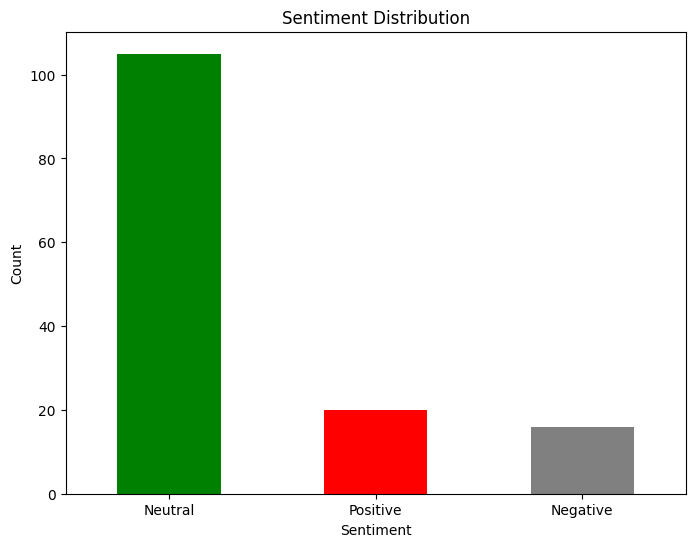

In [ ]:
    # Sentiment Analysis Visualization
    sentiment_counts = df_new['sentiment'].value_counts()

    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar', color=['gray', 'green', 'red'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

####Applying Named Entity Recognition (NER)

We define a function apply_ner that takes a text as input, processes it using spaCy, and extracts named entities.
Named entities are entities like persons, organizations, locations, etc.
The function is applied to the 'description' column of the DataFrame.

In [ ]:
# Install necessary libraries
!pip install spacy

# Import libraries
import spacy
import pandas as pd

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Function for Named Entity Recognition (NER)
def apply_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER to the 'description' column
df_new['named_entities'] = df_new['TEXTS'].apply(apply_ner)

# Display the DataFrame with NER results
print("\nDataFrame with Named Entity Recognition:")
print(df_new[['TEXTS', 'named_entities']])


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()



DataFrame with Named Entity Recognition:
                                                 TEXTS  \
0    Title: Tram 131 at Massarelos. Description: Po...   
1    Title: Museum horse tram 8 at Arrábida. Descri...   
2    Title: Zorra 58 at Massarelos. Description: At...   
3    Title: Museumtram 100 at Arrábida. Description...   
4    Title: Musemtram 104 at Massarelos. Descriptio...   
..                                                 ...   
439  Title: Museumtram 247 at Massarelos. Descripti...   
444  Title: Museumtram 274 at Arrábida. Description...   
445  Title: Museumtram 315 at Arrábida. Description...   
446  Title: Tram 191 at Massarelos. Description: Po...   
449  Title: Museumtrams 274 and 58 at Massarelos. D...   

                                        named_entities  
0    [(131, CARDINAL), (Massarelos, ORG), (portugal...  
1    [(8, CARDINAL), (Arrábida, GPE), (Annual, DATE...  
2    [(Massarelos, ORG), (annual, DATE), (Porto, GP...  
3    [(Museumtram, ORG), (100, CA

<ipython-input-72-b8ba45512f27>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['named_entities'] = df_new['TEXTS'].apply(apply_ner)


Now, we want to provide some examples and visualize the result with a simple bar chart.

2024-01-18 09:35:10.722292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 09:35:10.722354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 09:35:10.724138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 09:35:12.800023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


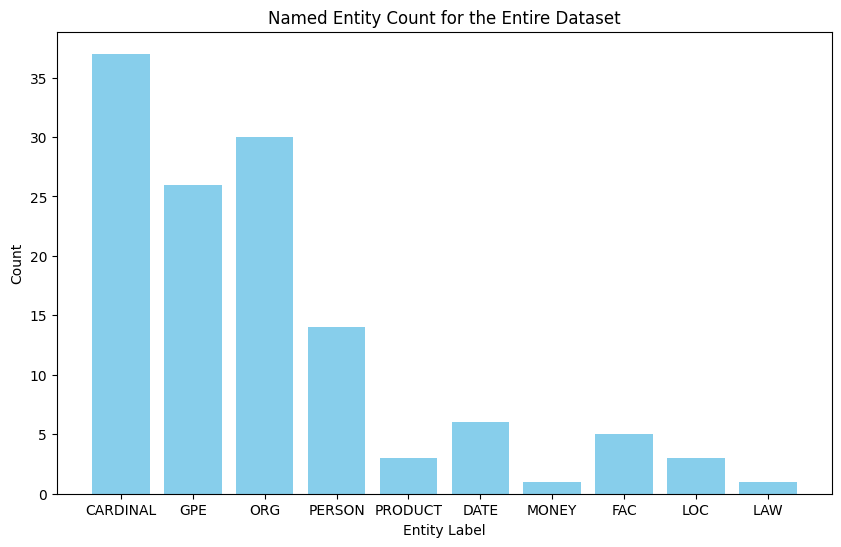


Named Entity Examples:

CARDINAL Examples:
  - 8
  - 100
  - 163
  - 247
  - 274

GPE Examples:
  - Arrábida
  - Arrábida
  - Arrábida
  - Arrábida
  - Arrábida

ORG Examples:
  - Zorra
  - Museumtram
  - Museumtram
  - Museumtram
  - Museumtram

PERSON Examples:
  - Musemtram 104
  - Almoço
  - Ponte da Arrábida
  - Joaquim Ferreira
  - Porto Tram

PRODUCT Examples:
  - 315
  - Xerocomellus
  - 315

DATE Examples:
  - 58
  - 76-2003-05-03-1-Betriebshof
  - 66-2003-05-04-1-Museum
  - 49-2003-05-04-1-Museum
  - 22-2003-05-04-1-Museum

MONEY Examples:
  - 26

FAC Examples:
  - 288
  - 288
  - 288
  - Cais das Pedras
  - Cais das Pedras

LOC Examples:
  - Douro River
  - Douro River
  - Douro River

LAW Examples:
  - Trailer 18


In [ ]:
# Importing necessary libraries
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import spacy

# Download spaCy English model
!python -m spacy download en_core_web_sm

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function for Named Entity Recognition (NER)
def apply_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Function for visualizing named entities with count and examples for the entire dataset
def visualize_ner_with_count(dataset):
    # Count and examples of named entities for the entire dataset
    entity_count = Counter()
    entity_examples = {}

    for index, row in dataset.iterrows():
        doc = nlp(row['title'])
        entity_count.update([ent.label_ for ent in doc.ents])

        for ent_label in entity_count.keys():
            entity_examples.setdefault(ent_label, []).extend(
                [ent.text for ent in doc.ents if ent.label_ == ent_label][:3]
            )

    if not entity_count:
        print("No named entities found.")
        return

    # Bar chart for entity counts
    labels, counts = zip(*entity_count.items())
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.title('Named Entity Count for the Entire Dataset')
    plt.xlabel('Entity Label')
    plt.ylabel('Count')
    plt.show()

    # Displaying 5 examples for each named entity label
    print("\nNamed Entity Examples:")
    for ent_label, examples in entity_examples.items():
        print(f"\n{ent_label} Examples:")
        for example in examples[:5]:
            print(f"  - {example}")

# Displaying the NER Visualization for the Entire Dataset
visualize_ner_with_count(df_new)

### Conclusion

Now you have the basic knowledge on how AI could be possibly use to collect social media posts from Flickr in your case study area. Keep us posted when you do find out some interesting facts.

#### Cite us as:

Bai, N., Ducci, M., Mirzikashvili, R., Nourian, P., and Pereira Roders, A.: MAPPING URBAN HERITAGE IMAGES WITH SOCIAL MEDIA DATA AND ARTIFICIAL INTELLIGENCE, A CASE STUDY IN TESTACCIO, ROME, Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XLVIII-M-2-2023, 139–146, https://doi.org/10.5194/isprs-archives-XLVIII-M-2-2023-139-2023, 2023.


Bai, N. (2023). Sensing the Cultural Significance with AI for Social Inclusion: A Computational Spatiotemporal Network-based Framework of Heritage Knowledge Documentation using User-Generated Content. [Dissertation (TU Delft), Delft University of Technology]. A+BE | Architecture and the Built Environment. https://doi.org/10.7480/abe.2023.17


Foroughi, M. (2023). Heritage Beyond Singular Narratives: Embracing Diversity in Participatory Heritage Planning Empowered by ­Artificial Intelligence. [Dissertation (TU Delft), Delft University of Technology]. https://doi.org/10.7480/abe.2023.19

Foroughi, M., de Andrade, B. and Roders, A.P., 2023. Capturing public voices: The role of social media in heritage management. Habitat International, 142, p.102934. https://doi.org/10.1016/j.habitatint.2023.102934

Foroughi, M., de Andrade, B. and Roders, A.P., 2022. Peoples’ values and feelings matter: participatory heritage management using social media. In Artificial Intelligence and Architectural Design: An Introduction (pp. 107-120). https://research.tudelft.nl/en/publications/peoples-values-and-feelings-matter-participatory-heritage-managem

#### Aknowledgement

Contributions

Dr. **Nan Bai**: Conceptualization, Introduction, Data Collection, Dataset Exploration, Image Processing using AI models, Text Processing using AI Models (Preprocessing of Textual Information), Conclusion

Dr. **Mahda Foroughi**: Conceptualization, Introduction, Text Processing using AI Models, Conclusion

The following blog post has been greatly helpful for the preparation of this Google Colab notebook:
https://nextjournal.com/ml4a/image-t-sne